In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = {'png', 'retina'}
import os, zipfile, io, re
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.applications.xception import Xception
from keras.models import Model, load_model
from keras.layers.core import Dense
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
image_size = 200
classes = ['White', 'Black', 'Asian', 'Indian', 'Others']
num_classes = len(classes)

In [3]:
%%time
# ZIP読み込み
z = zipfile.ZipFile('data/UTKFace.zip')
# 画像ファイルパスのみ取得
imgfiles = [ x for x in z.namelist() if re.search(r"^UTKFace.*jpg$", x)]

X = []
Y = []
for imgfile in imgfiles:
    # ZIPから画像読み込み
    image = Image.open(io.BytesIO(z.read(imgfile)))
    # RGB変換
    image = image.convert('RGB')
    # リサイズ
    image = image.resize((image_size, image_size))
    # 画像から配列に変換
    data = np.asarray(image)
    file = os.path.basename(imgfile)
    file_split = [i for i in file.split('_')]
    X.append(data)
    Y.append(file_split[2])
z.close()
del z, imgfiles

X = np.array(X)
Y = np.array(Y)
print(X.shape, Y.shape)

(23697, 200, 200, 3) (23697,)
CPU times: user 19.1 s, sys: 649 ms, total: 19.8 s
Wall time: 19.8 s


In [4]:
# trainデータとtestデータに分割
X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    random_state = 0,
    #stratify = Y,
    test_size = 0.1
)
del X,Y
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(21327, 200, 200, 3) (21327,) (2370, 200, 200, 3) (2370,)


In [5]:
# データ型の変換＆正規化
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
# one-hot変換
y_train = to_categorical(y_train, num_classes = num_classes)
y_test = to_categorical(y_test, num_classes = num_classes)

In [6]:
# trainデータからvalidデータを分割
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    random_state = 0,
    stratify = y_train,
    test_size = 0.2
)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape) 

(17061, 200, 200, 3) (17061, 5) (4266, 200, 200, 3) (4266, 5)


In [7]:
base_model = Xception(
    include_top = False,
    weights = "imagenet",
    input_shape = None
)

In [8]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(num_classes, activation = 'softmax')(x)

In [9]:
datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = False
)

In [10]:
# EarlyStopping
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    verbose = 1
)

# ModelCheckpoint
weights_dir = './weights/'
if os.path.exists(weights_dir) == False:os.mkdir(weights_dir)
model_checkpoint = ModelCheckpoint(
    weights_dir + "val_loss{val_loss:.3f}.hdf5",
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    period = 3
)

# reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 3,
    verbose = 1
)

# log for TensorBoard
logging = TensorBoard(log_dir = "log/")

In [11]:
# ネットワーク定義
model = Model(inputs = base_model.input, outputs = predictions)

#108層までfreeze
for layer in model.layers[:108]:
    layer.trainable = False

    # Batch Normalizationのfreeze解除
    if layer.name.startswith('batch_normalization'):
        layer.trainable = True
    if layer.name.endswith('bn'):
        layer.trainable = True

#109層以降、学習させる
for layer in model.layers[108:]:
    layer.trainable = True

# layer.trainableの設定後にcompile
model.compile(
    optimizer = Adam(),
    loss = 'categorical_crossentropy',
    metrics = ["accuracy"]
)

In [12]:
%%time
hist = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size = 32),
    steps_per_epoch = X_train.shape[0] // 32,
    epochs = 50,
    validation_data = (X_test, y_test),
    callbacks = [early_stopping, reduce_lr, logging],
    shuffle = True,
    verbose = 1
)

Epoch 1/50
533/533 [==============================] - 251s 470ms/step - loss: 0.8272 - acc: 0.7054 - val_loss: 0.7325 - val_acc: 0.7700
Epoch 2/50
533/533 [==============================] - 249s 467ms/step - loss: 0.5961 - acc: 0.7937 - val_loss: 0.6998 - val_acc: 0.7738
Epoch 3/50
533/533 [==============================] - 248s 466ms/step - loss: 0.5257 - acc: 0.8160 - val_loss: 0.5516 - val_acc: 0.8160
Epoch 4/50
533/533 [==============================] - 249s 467ms/step - loss: 0.4602 - acc: 0.8420 - val_loss: 0.6059 - val_acc: 0.7975
Epoch 5/50
533/533 [==============================] - 248s 466ms/step - loss: 0.4110 - acc: 0.8610 - val_loss: 0.5347 - val_acc: 0.8228
Epoch 6/50
533/533 [==============================] - 249s 467ms/step - loss: 0.3659 - acc: 0.8752 - val_loss: 0.5858 - val_acc: 0.8287
Epoch 7/50
533/533 [==============================] - 247s 464ms/step - loss: 0.3201 - acc: 0.8890 - val_loss: 0.6050 - val_acc: 0.8203
Epoch 8/50
533/533 [============================

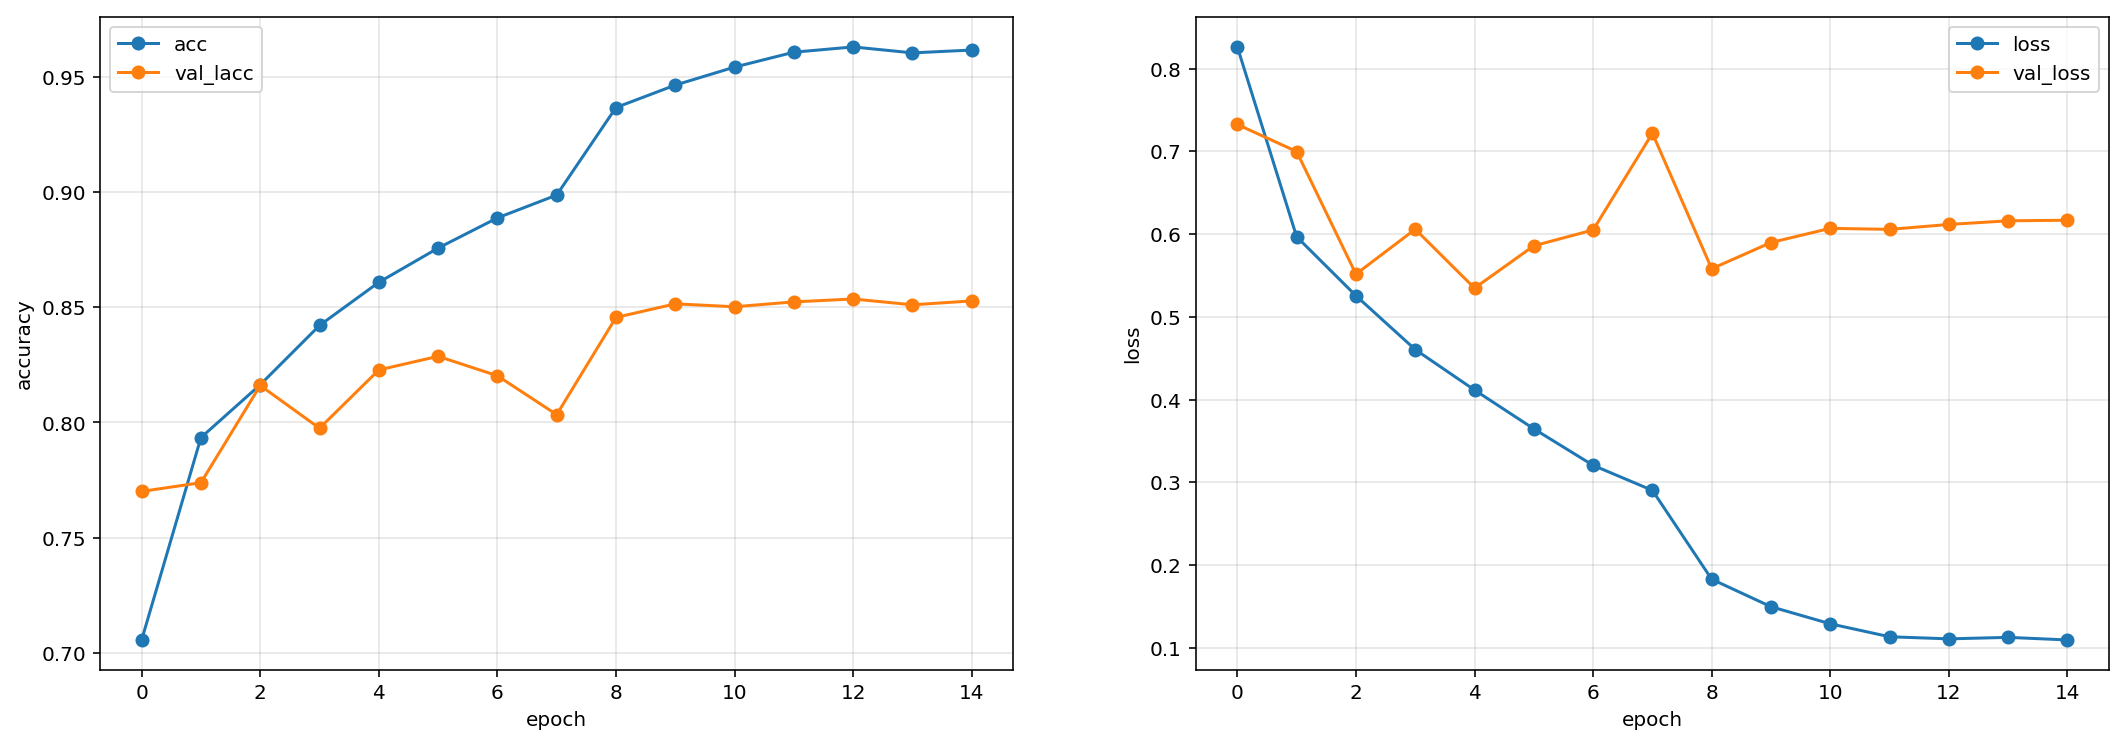

In [13]:
plt.figure(figsize=(18, 6))

#accuracy
plt.subplot(1, 2, 1)
plt.plot(hist.history["acc"], label="acc", marker = "o")
plt.plot(hist.history["val_acc"], label="val_lacc", marker="o")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc = "best")
plt.grid(color="gray", alpha=0.2)

#loss
plt.subplot(1, 2, 2)
plt.plot(hist.history["loss"], label="loss", marker="o")
plt.plot(hist.history["val_loss"], label="val_loss", marker="o")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc = "best")
plt.grid(color='gray', alpha=0.2)

plt.show()

In [14]:
score = model.evaluate(X_test, y_test, verbose=1)
print("evaluate loss : {[0]:.4f}".format(score))
print("evaluate loss : {[1]:.1%}".format(score))

2370/2370 [==============================] - 5s 2ms/step
evaluate loss : 0.6167
evaluate loss : 85.3%


In [15]:
model_dir = 'data/model/'
if os.path.exists(model_dir) == False:
    os.mkdir(model_dir)
    
model.save(model_dir + 'race_model.hdf5')

#model without an optimizer(it can be used only for prediction, not for training and evaluation)
model.save(model_dir + 'race_model_without_opt.hdf5', include_optimizer = False)

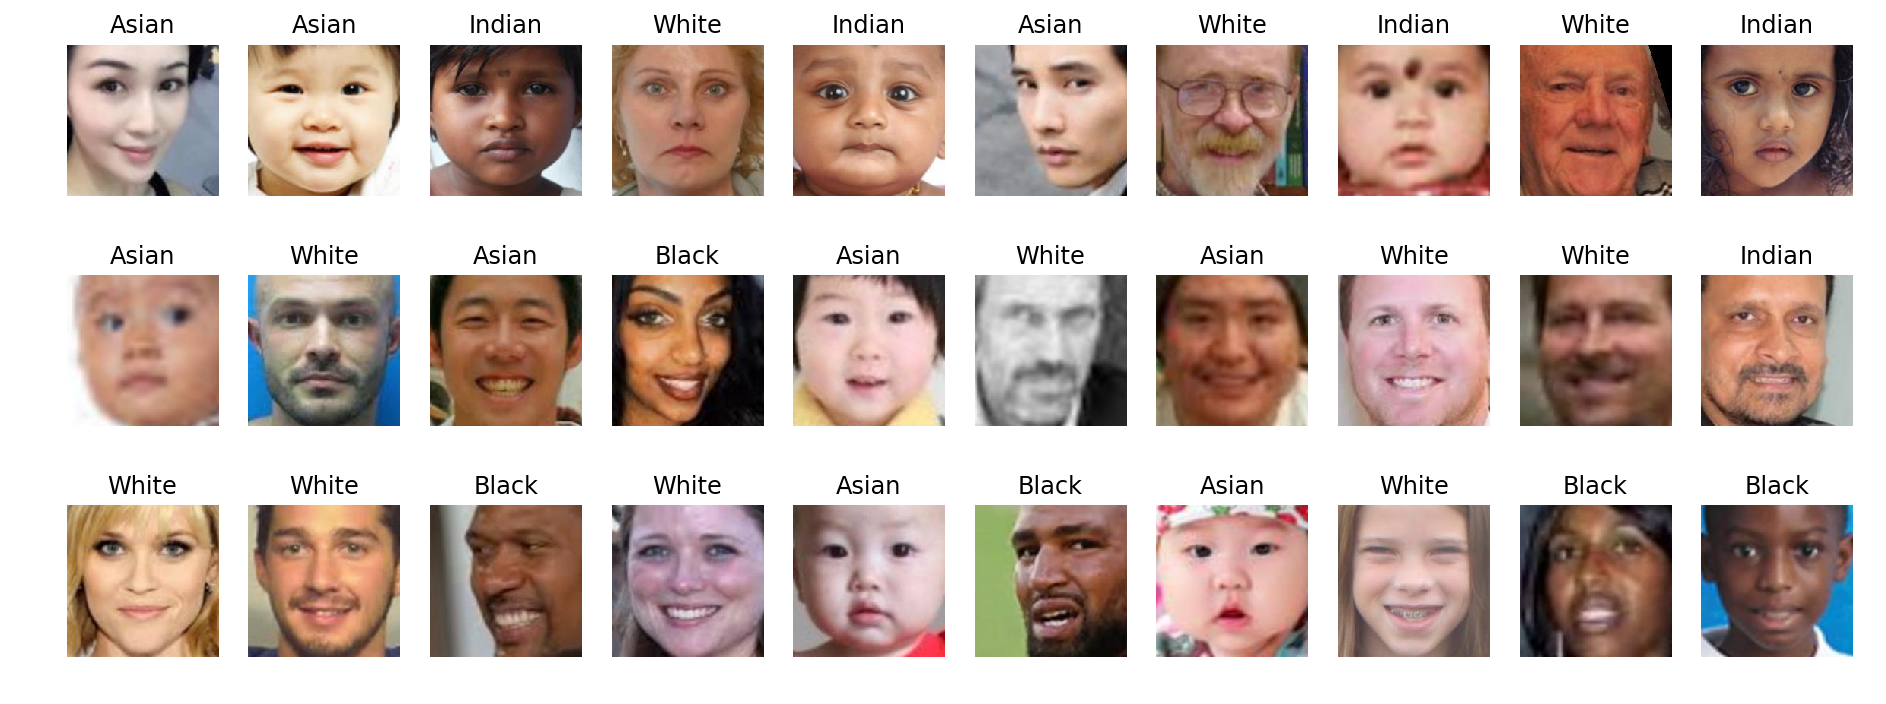

In [16]:
#show images for test data(first 30 data)
true_classes = np.argmax(y_test[0:30], axis=1)

plt.figure(figsize = (16, 6))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.axis("off")
    plt.title(classes[true_classes[i]])
    plt.imshow(X_test[i])
plt.show()

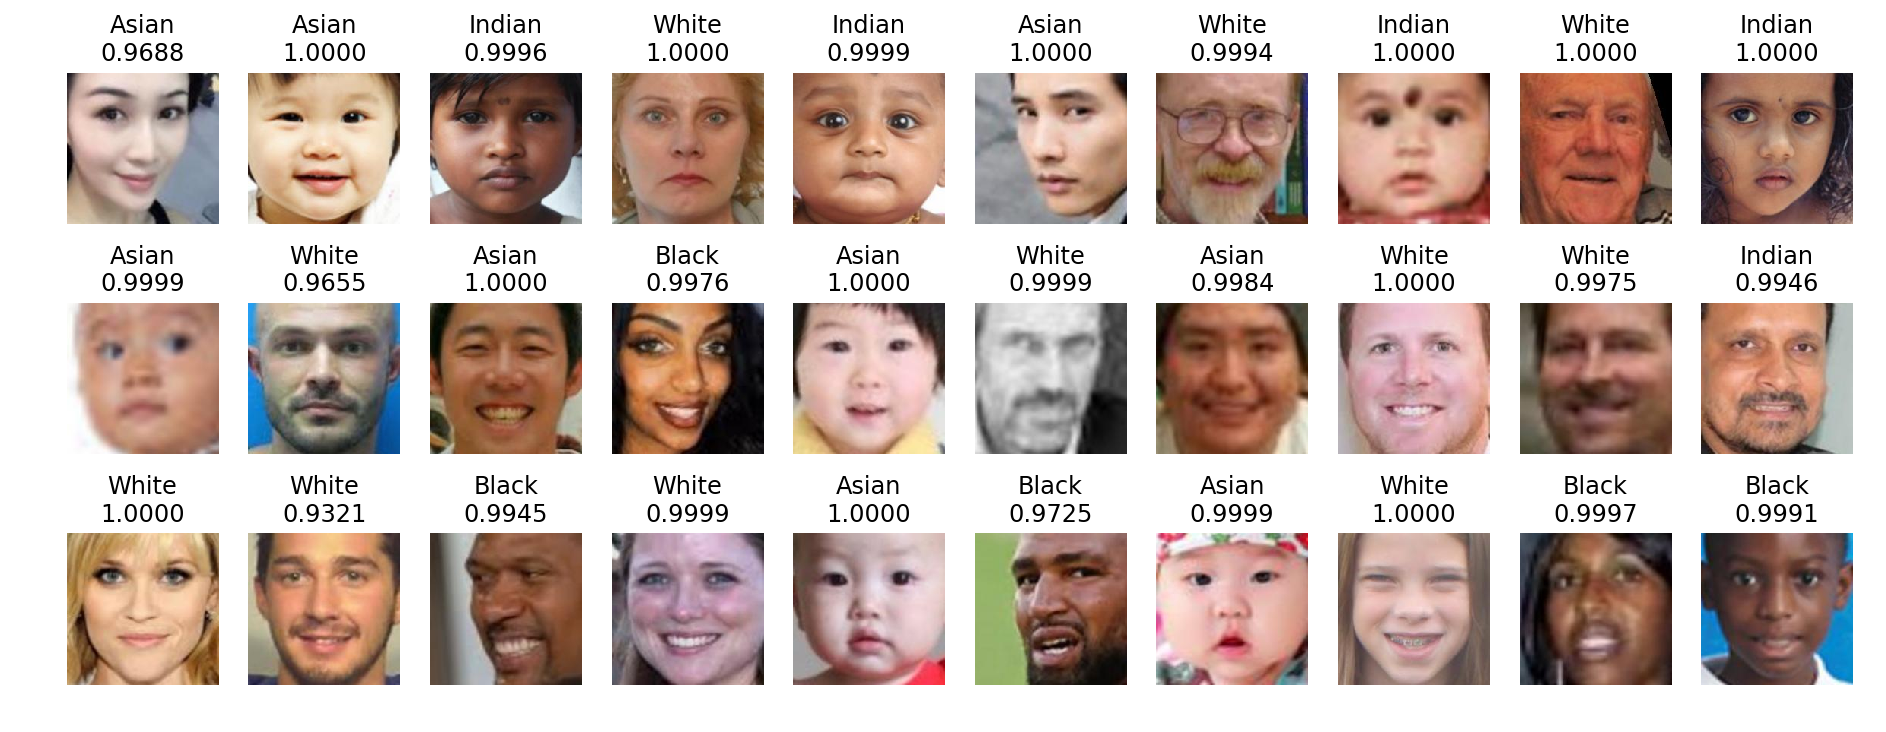

In [17]:
#show predicted results
pred_classes = np.argmax(model.predict(X_test[0:30]), axis = 1)

pred_probs = np.max(model.predict(X_test[0:30]), axis = 1)
pred_probs = ['{:.4f}'.format(i) for i in pred_probs]

plt.figure(figsize = (16, 6))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.axis("off")
    if pred_classes[i] == true_classes[i]:
        plt.title(classes[pred_classes[i]]+'\n'+pred_probs[i])
    else:
        plt.title(classes[pred_classes[i]]+'\n'+pred_probs[i], color="red")
    plt.imshow(X_test[i])
plt.show()

In [18]:
#labels for test data
true_classes = np.argmax(y_test, axis = 1)

#predicted value for test data
pred_classes = np.argmax(model.predict(X_test), axis = 1)

pred_probs = np.max(model.predict(X_test), axis = 1)
pred_probs = np.round(pred_probs, 2)
pred_probs = ['{:.4f}'.format(i) for i in pred_probs]

In [20]:
#to check correct and incorrect data
correct = []
incorrect = []

for i in range(len(X_test)):
    if pred_classes[i] == true_classes[i]:
        correct.append((X_test[i], classes[pred_classes[i]], pred_probs[i]))
    else:
        incorrect.append((X_test[i], classes[pred_classes[i]], pred_probs[i]))
        
print("number of correct:", len(correct))
print("number of incorrect:", len(incorrect))

number of correct: 2021
number of incorrect: 349


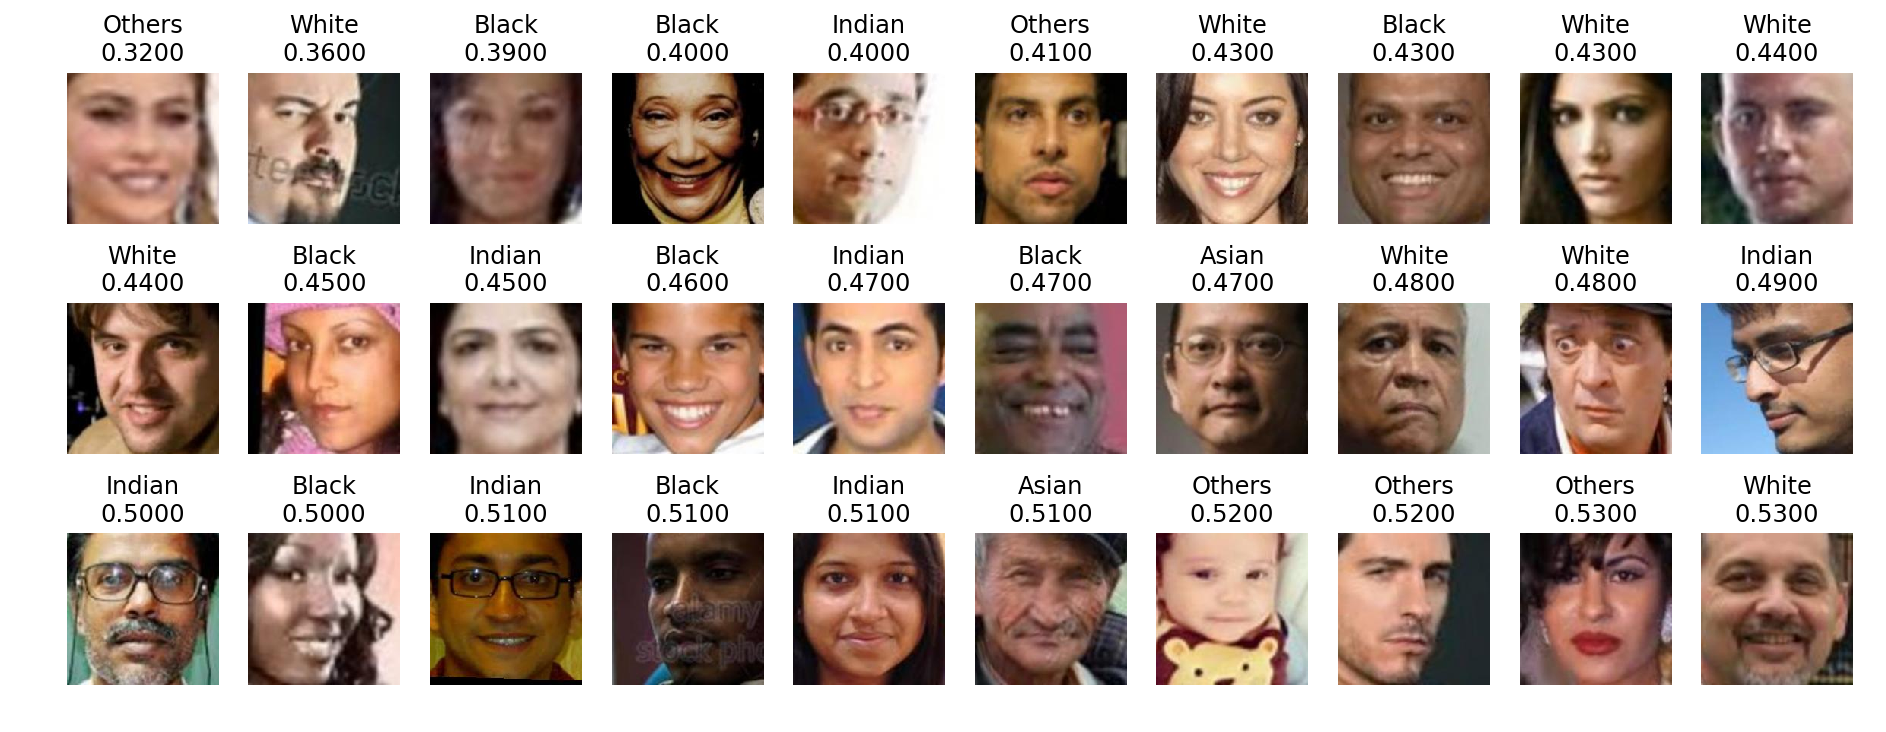

In [21]:
#x[2] means pred_probs[i] in the above case
correct.sort(key = lambda x:x[2])

plt.figure(figsize=(16, 6))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.axis("off")
    plt.title(correct[i][1]+'\n'+correct[i][2])
    plt.imshow(correct[i][0])
plt.show()

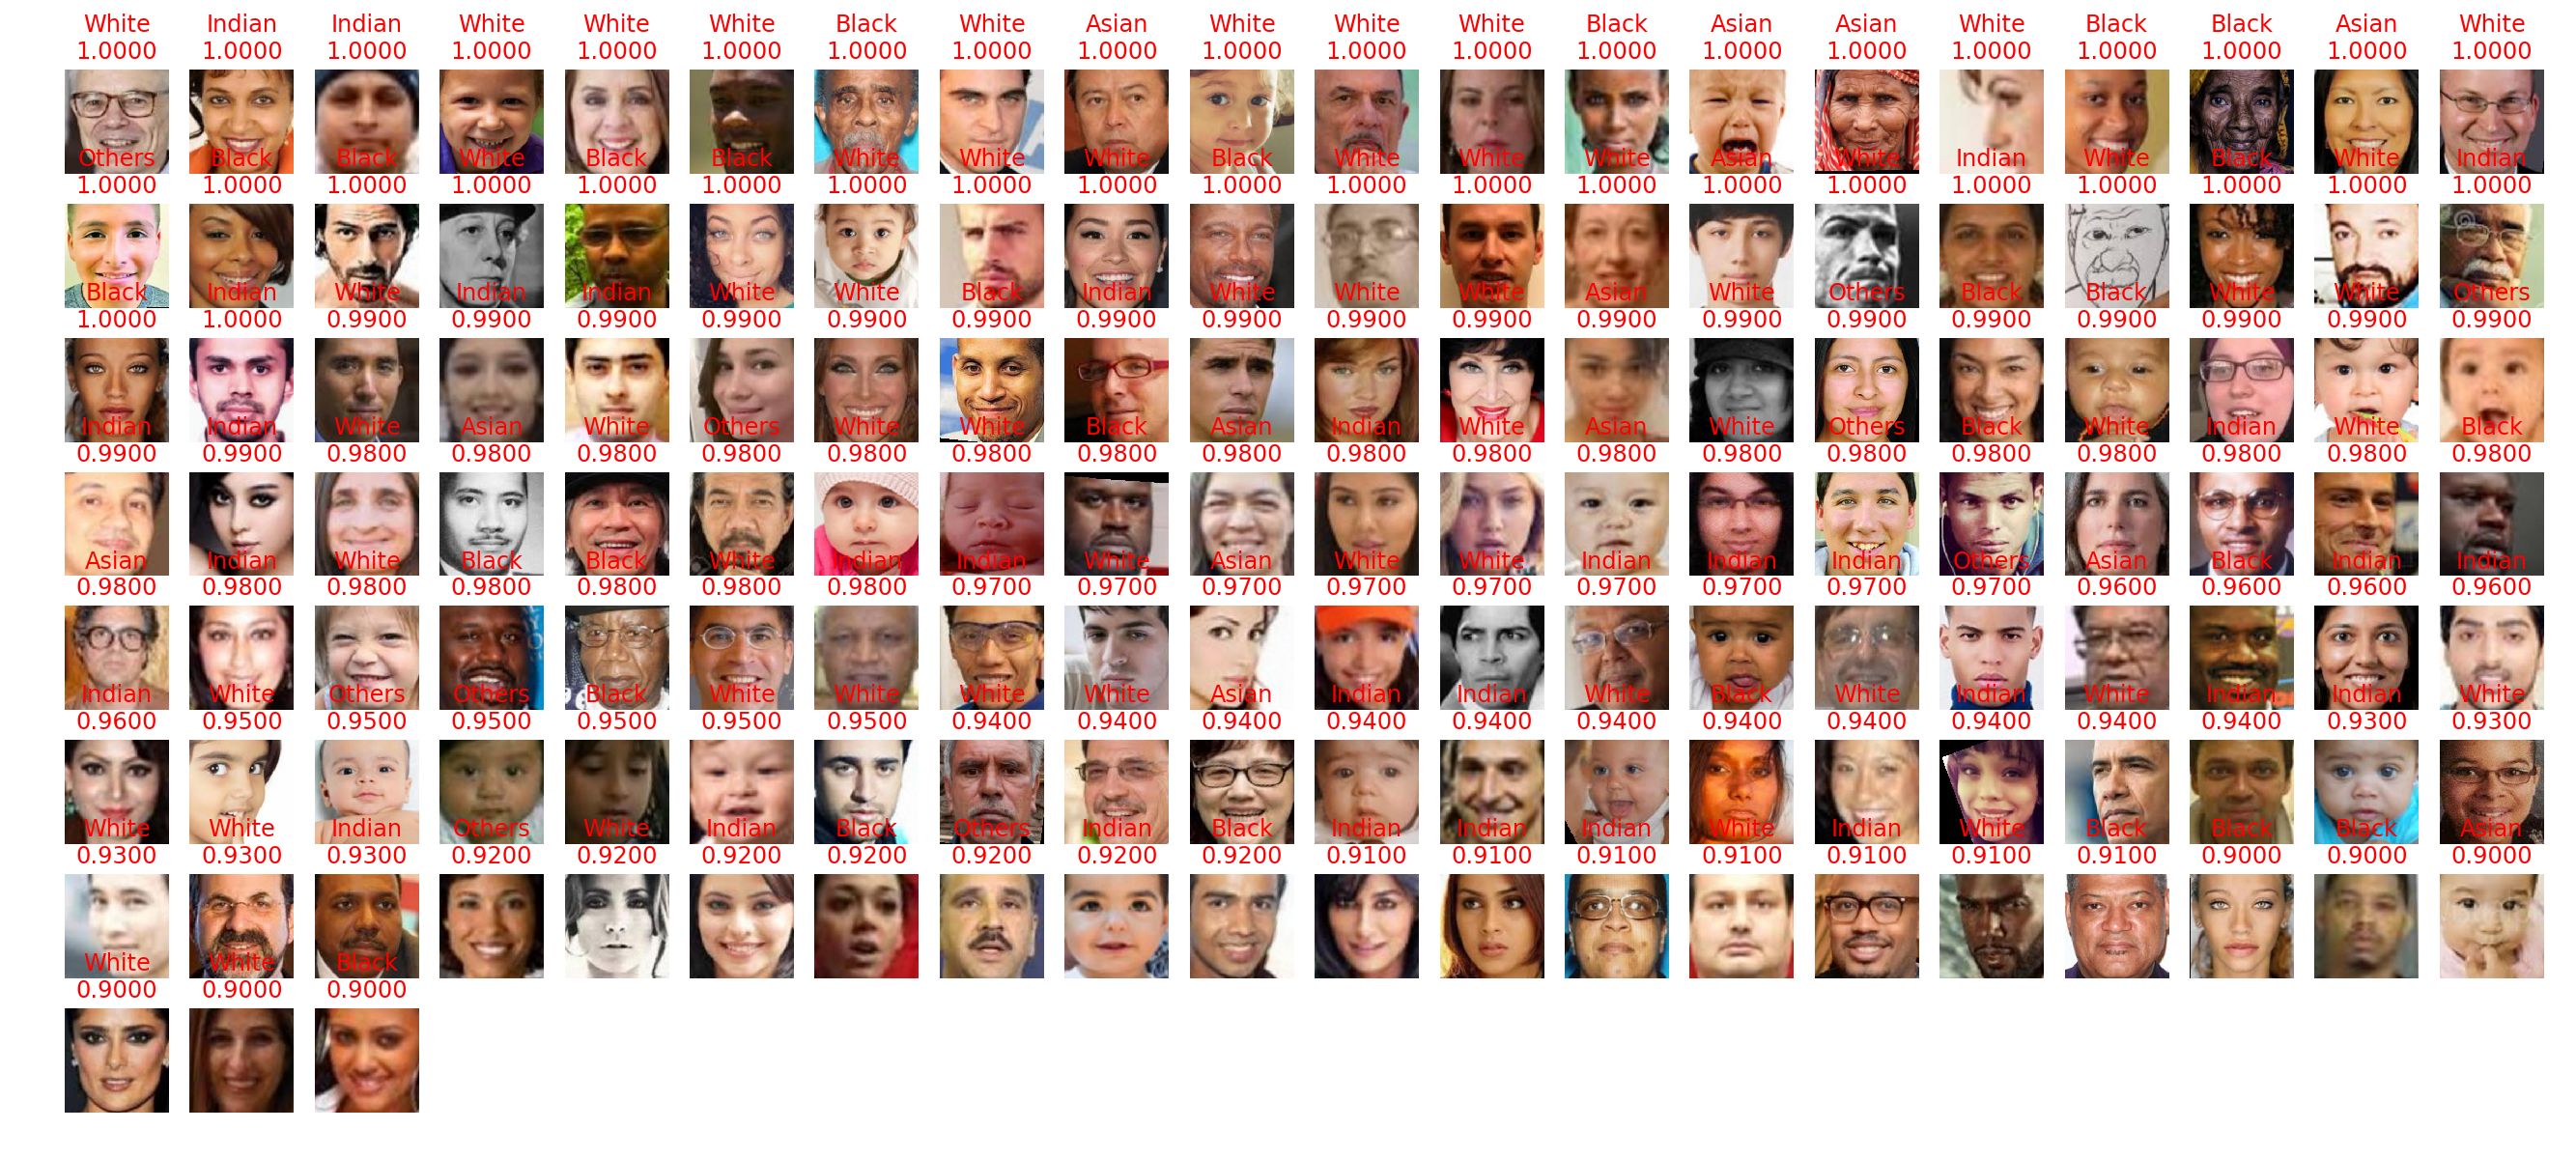

In [22]:
incorrect.sort(key = lambda x:x[2], reverse = True)

plt.figure(figsize = (23, 10))
for i in range(143):
    plt.subplot(8, 20, i + 1)
    plt.axis("off")
    plt.title(incorrect[i][1]+'\n'+incorrect[i][2], color='red')
    plt.imshow(incorrect[i][0])
plt.show()

In [23]:
from sklearn.metrics import confusion_matrix

confusion_matrix(true_classes, pred_classes)

array([[911,  22,  12,  26,  39],
       [ 14, 416,   4,  22,  11],
       [ 21,   3, 298,   8,   5],
       [ 32,  17,   3, 326,  12],
       [ 53,  18,   8,  19,  70]])